#**PROBLEMA DE NEGOCIO**


---


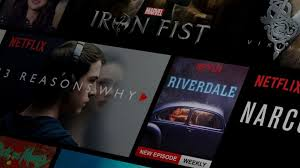

##Imagina tener acceso a los datos de una plataforma de streaming y usar esos datos para mejorar la experiencia del usuario. Como científicos de datos, analizarán estos datos con Python y construirán un recomendador de películas personalizado que ofrecerá sugerencias precisas y relevantes, revolucionando la forma en que los usuarios descubren nuevos contenidos.

### **Objetivos**

1. Recomendador no personalizado

2. Recomendador Content-based

3. Recomendador Collaborative filtering

#**1. Configuración del Ambiente**


---


In [115]:
#Librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import zipfile
import warnings
import plotly.express as px
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import linear_kernel
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
!curl http://files.grouplens.org/datasets/movielens/ml-latest-small.zip -o ml-latest-small.zip
with zipfile.ZipFile('ml-latest-small.zip', 'r') as zip_ref:
    zip_ref.extractall('data')
global df_movies, df_ratings, df_final

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0  2353k      0 --:--:-- --:--:-- --:--:-- 2358k


#**2. Obtención, Tratamiento y Análisis Exploratório (EDA)**

------

##**2.1 Cargando las bases de datos**

In [116]:
df_movies = pd.read_csv('data/ml-latest-small/movies.csv')
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [117]:
df_ratings = pd.read_csv('data/ml-latest-small/ratings.csv')
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.00,964982703
1,1,3,4.00,964981247
2,1,6,4.00,964982224
3,1,47,5.00,964983815
4,1,50,5.00,964982931


##**2.2 Tratamiento de Datos**

In [118]:
print(df_movies.info())
print('-------------')
print(df_ratings.info())
print('-------------')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None
-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None
-------------


In [119]:
df_movies.describe()

,movieId
count,9742.00
mean,42200.35
std,52160.49
min,1.00
25%,3248.25
50%,7300.00
75%,76232.00
max,193609.00


In [120]:
df_ratings.describe()

,userId,movieId,rating,timestamp
count,100836.00,100836.00,100836.00,100836.00
mean,326.13,19435.30,3.50,1205946087.37
std,182.62,35530.99,1.04,216261036.00
min,1.00,1.00,0.50,828124615.00
25%,177.00,1199.00,3.00,1019123866.00
50%,325.00,2991.00,3.50,1186086662.00
75%,477.00,8122.00,4.00,1435994144.50
max,610.00,193609.00,5.00,1537799250.00


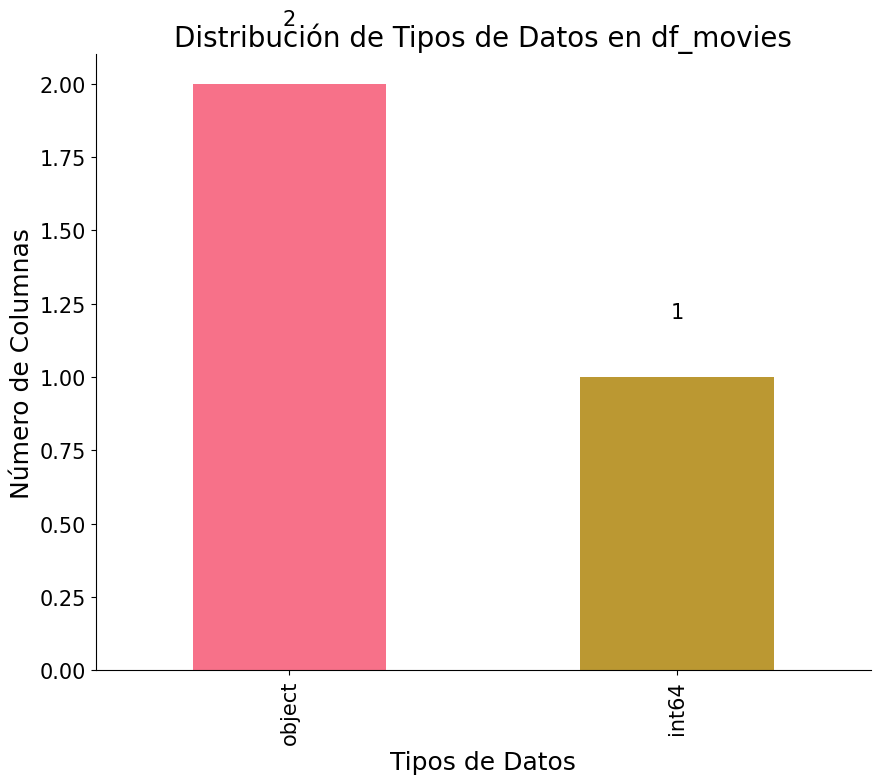

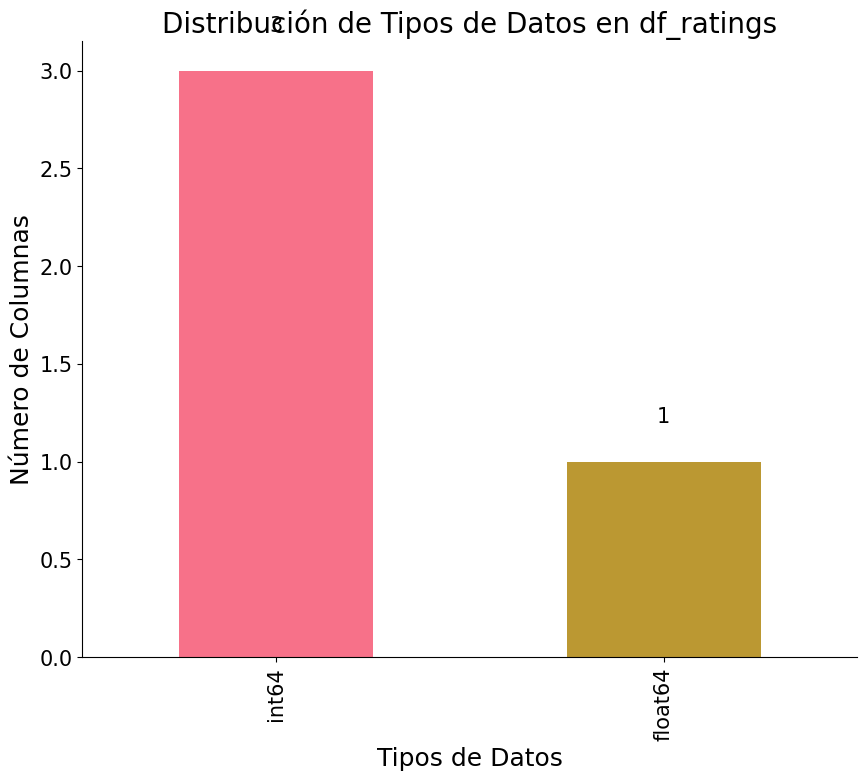

In [121]:
dataframes = [df_movies, df_ratings]
df_names = ['df_movies', 'df_ratings']

for df, name in zip(dataframes, df_names):
    plt.figure(figsize=(10, 8))
    ax = df.dtypes.value_counts().plot(kind='bar', color=sns.color_palette("husl"), grid=False, fontsize=15)

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 0.2, height, ha='center', size=15)

    ax.set_xlabel("Tipos de Datos", fontsize=18)
    ax.set_ylabel("Número de Columnas", fontsize=18)
    ax.set_title(f"Distribución de Tipos de Datos en {name}", fontsize=20)

    sns.despine()
    plt.show()

<Figure size 1000x600 with 0 Axes>

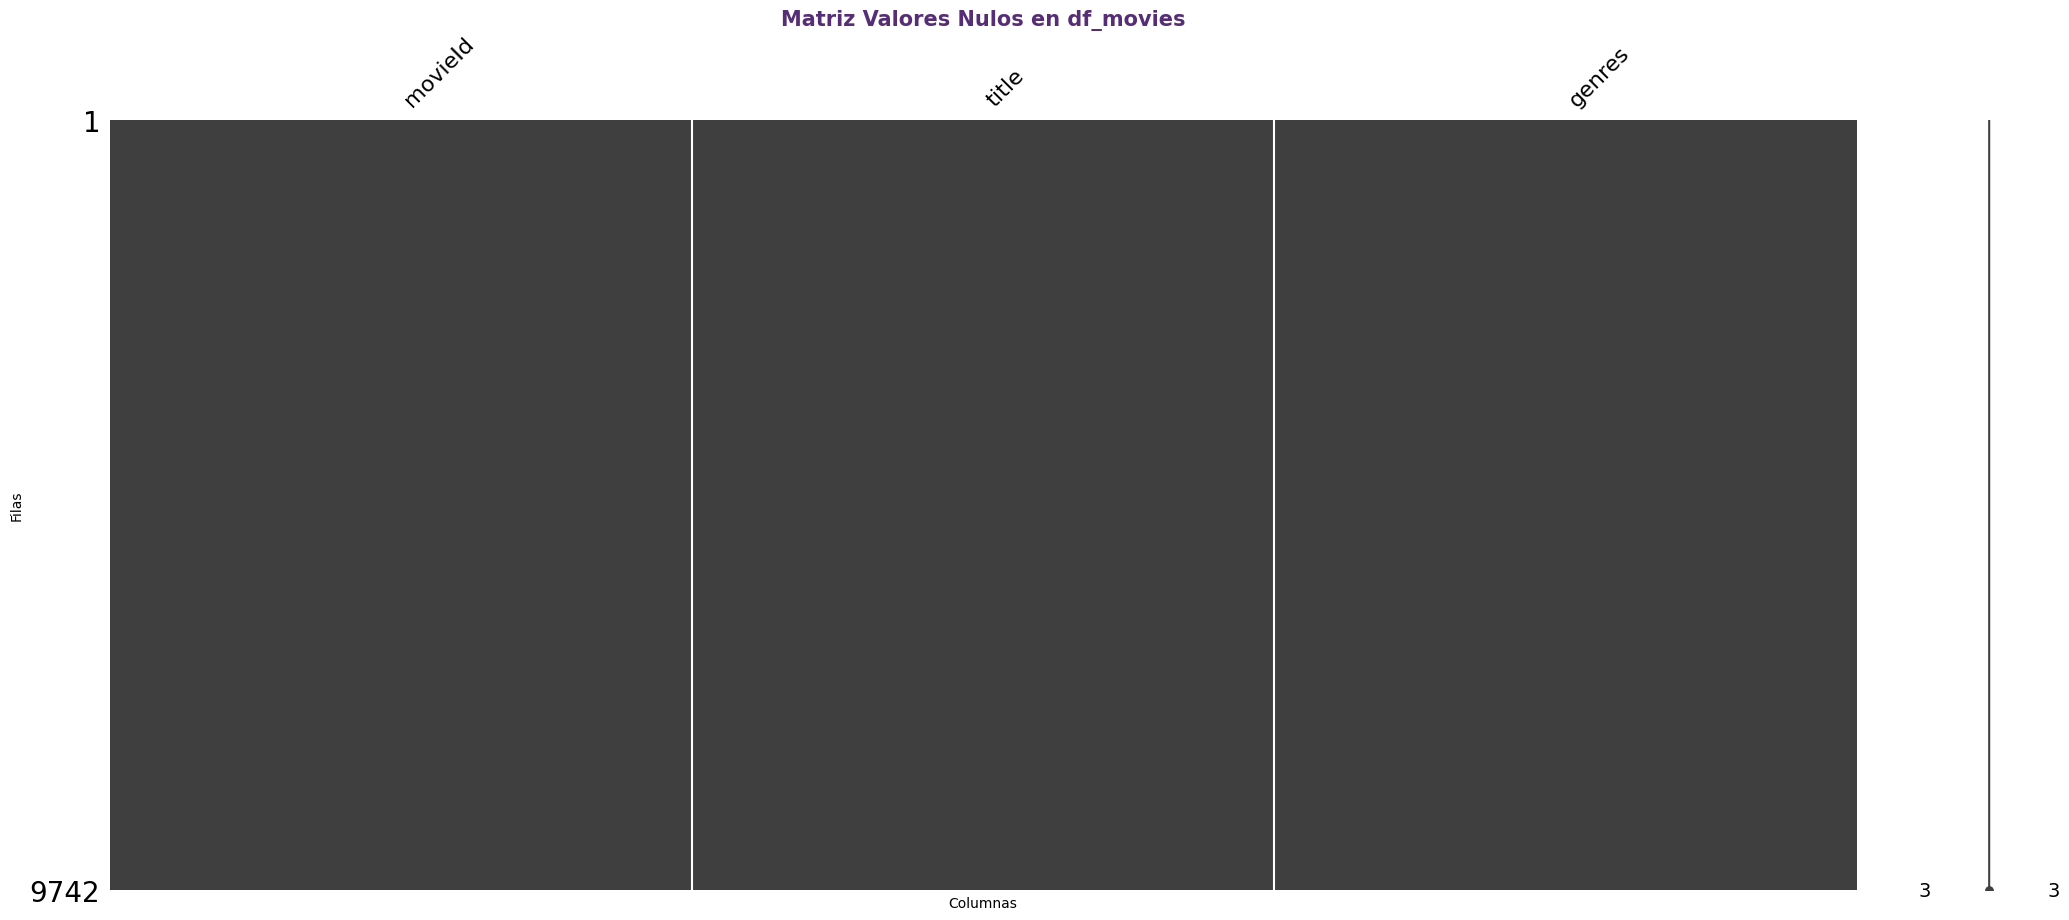

<Figure size 1000x600 with 0 Axes>

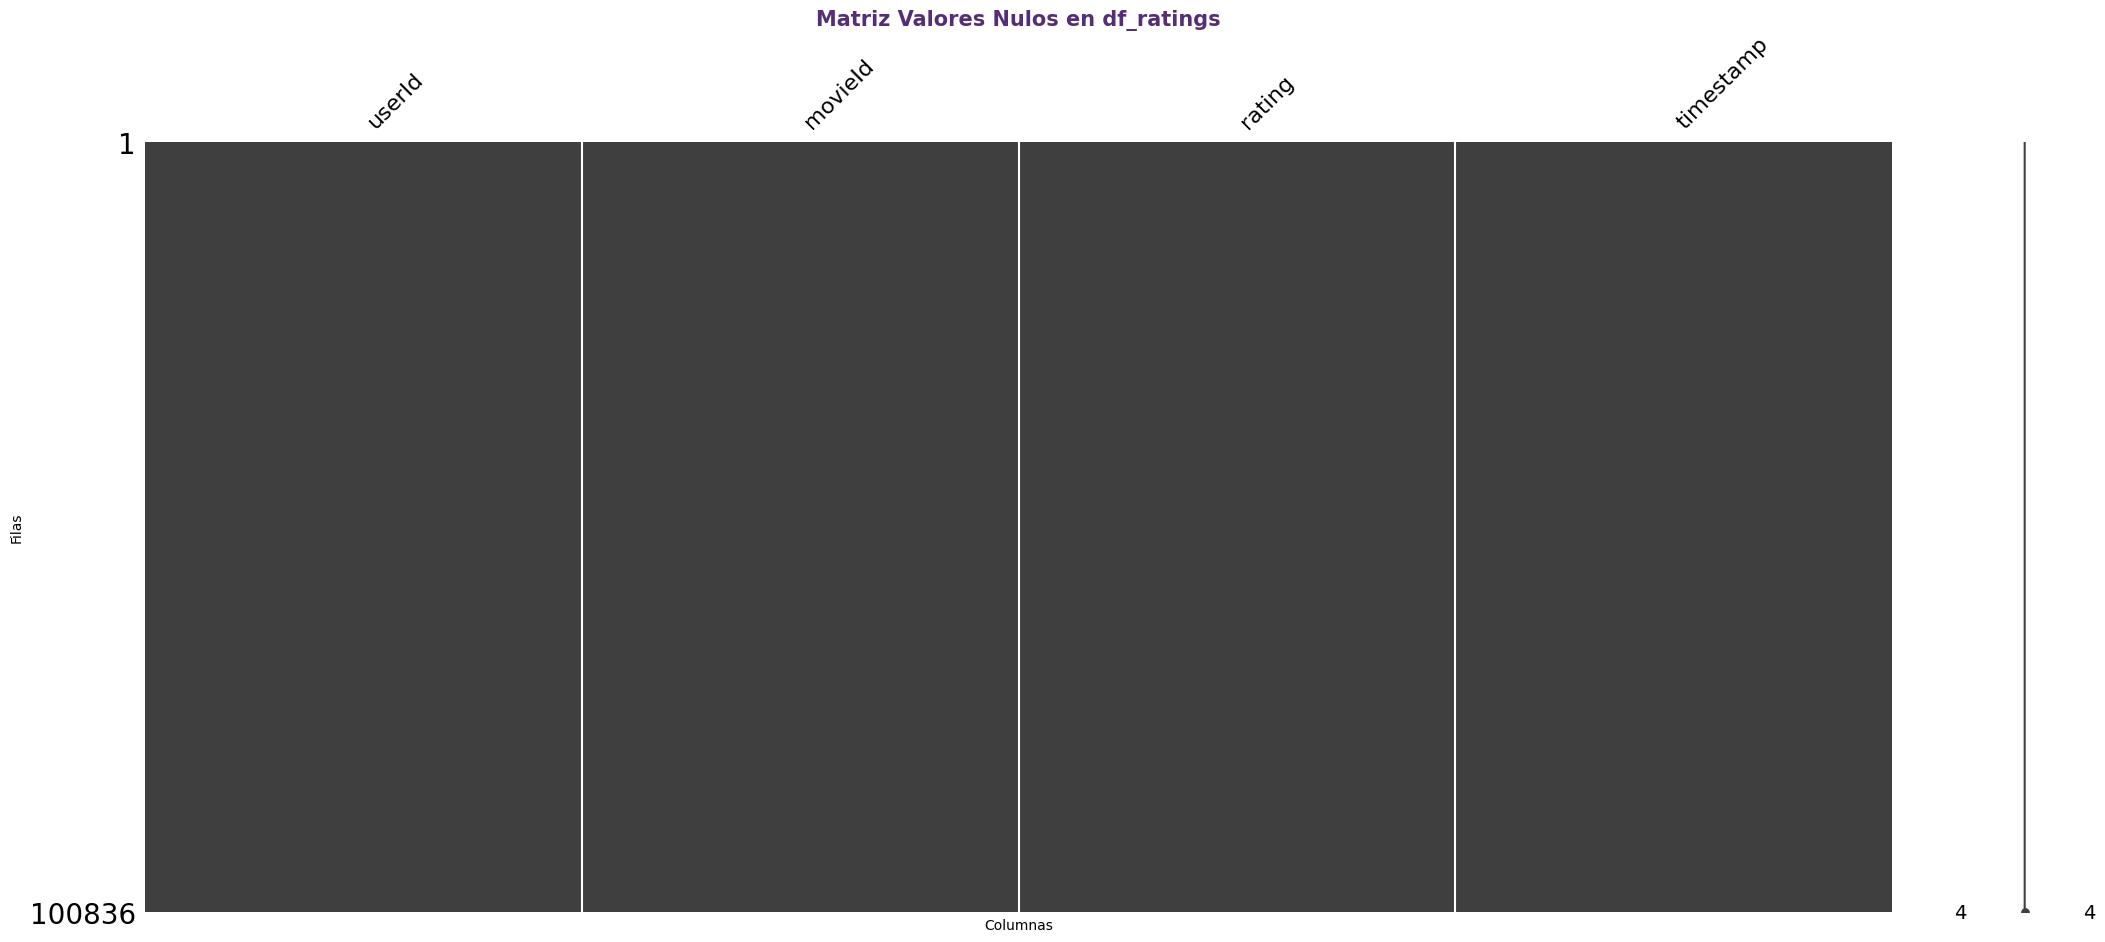

In [122]:
#Matriz de valores nulos
import missingno as msno
import matplotlib.pyplot as plt

dataframes = [df_movies,df_ratings]
df_names = ['df_movies', 'df_ratings']

for df, name in zip(dataframes, df_names):
    plt.figure(figsize=(10, 6))
    msno.matrix(df)
    plt.title(f'Matriz Valores Nulos en {name}', fontdict={'fontsize': 15, 'fontweight': 'bold', 'color': '#552E75'})
    plt.xlabel('Columnas')
    plt.ylabel('Filas')
    plt.show()

In [123]:
def visualizar_nulos():
    global df_movies, df_ratings

    print("Valores nulos en df_movies:\n", df_movies.isnull().sum())
    print('-------------')
    print("\nValores nulos en df_ratings:\n", df_ratings.isnull().sum())
    print('-------------')

visualizar_nulos()

Valores nulos en df_movies:
 movieId    0
title      0
genres     0
dtype: int64
-------------

Valores nulos en df_ratings:
 userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
-------------


No se evidencian valores nulos en nuestros dataframe

In [124]:
def preprocesamiento():
    global df_movies, df_ratings


    # Paso 2: Eliminar registros con valores nulos
    df_movies.dropna(inplace=True)
    df_ratings.dropna(inplace=True)

    # Paso 3: Eliminar registros duplicados en df_movies (considerando movieId como llave)
    df_movies.drop_duplicates(subset='movieId', inplace=True)

    # Paso 4: Eliminar registros duplicados en df_ratings (considerando movieId y userId como llaves)
    df_ratings.drop_duplicates(subset=['movieId', 'userId'], inplace=True)

    # Paso 5: Crear la columna 'content' en df_movies reemplazando '|' por ' '
    df_movies['content'] = df_movies['genres'].str.replace('|', ' ')

    # Paso 6: Crear la columna 'genre_set' en df_movies como un conjunto de géneros
    df_movies['genre_set'] = df_movies['genres'].apply(lambda x: set(x.split('|')))

    # Paso 7: Asegurar que las columnas tengan el tipo de datos correcto
    df_movies['movieId'] = df_movies['movieId'].astype(int)
    df_movies['title'] = df_movies['title'].astype(str)
    df_movies['genres'] = df_movies['genres'].astype(str)

    df_ratings['movieId'] = df_ratings['movieId'].astype(int)
    df_ratings['userId'] = df_ratings['userId'].astype(int)
    df_ratings['rating'] = df_ratings['rating'].astype(float)
    df_ratings['timestamp'] = pd.to_datetime(df_ratings['timestamp'], unit='s')

    # Mostrar los tipos de datos para verificar
    print("Tipos de datos en df_movies:")
    print(df_movies.dtypes)

    print("\nTipos de datos en df_ratings:")
    print(df_ratings.dtypes)

# Llamar a la función de preprocesamiento
preprocesamiento()


Tipos de datos en df_movies:
movieId       int64
title        object
genres       object
content      object
genre_set    object
dtype: object

Tipos de datos en df_ratings:
userId                int64
movieId               int64
rating              float64
timestamp    datetime64[ns]
dtype: object


In [125]:
preprocesamiento()
print(df_movies.info())
print('-------------')
print(df_ratings.info())
print('-------------')

Tipos de datos en df_movies:
movieId       int64
title        object
genres       object
content      object
genre_set    object
dtype: object

Tipos de datos en df_ratings:
userId                int64
movieId               int64
rating              float64
timestamp    datetime64[ns]
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   movieId    9742 non-null   int64 
 1   title      9742 non-null   object
 2   genres     9742 non-null   object
 3   content    9742 non-null   object
 4   genre_set  9742 non-null   object
dtypes: int64(1), object(4)
memory usage: 380.7+ KB
None
-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   userId     100836 non-null  int64      

In [126]:
df_movies.head()

,movieId,title,genres,content,genre_set
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Comedy, Animation, Adventure, Fantasy, Children}"
1,2,Jumanji (1995),Adventure|Children|Fantasy,Adventure Children Fantasy,"{Adventure, Fantasy, Children}"
2,3,Grumpier Old Men (1995),Comedy|Romance,Comedy Romance,"{Romance, Comedy}"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Comedy Drama Romance,"{Drama, Comedy, Romance}"
4,5,Father of the Bride Part II (1995),Comedy,Comedy,{Comedy}


In [127]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.00,2000-07-30 18:45:03
1,1,3,4.00,2000-07-30 18:20:47
2,1,6,4.00,2000-07-30 18:37:04
3,1,47,5.00,2000-07-30 19:03:35
4,1,50,5.00,2000-07-30 18:48:51


##**2.3 Analisis exploratio (EDA)**

In [128]:
# Inspeccionar el DataFrame df_movies
print("Primeras filas de df_movies:")
df_movies.head()

Primeras filas de df_movies:


,movieId,title,genres,content,genre_set
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Comedy, Animation, Adventure, Fantasy, Children}"
1,2,Jumanji (1995),Adventure|Children|Fantasy,Adventure Children Fantasy,"{Adventure, Fantasy, Children}"
2,3,Grumpier Old Men (1995),Comedy|Romance,Comedy Romance,"{Romance, Comedy}"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Comedy Drama Romance,"{Drama, Comedy, Romance}"
4,5,Father of the Bride Part II (1995),Comedy,Comedy,{Comedy}


In [129]:
print("\nInformación sobre df_movies:")
df_movies.info()



Información sobre df_movies:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   movieId    9742 non-null   int64 
 1   title      9742 non-null   object
 2   genres     9742 non-null   object
 3   content    9742 non-null   object
 4   genre_set  9742 non-null   object
dtypes: int64(1), object(4)
memory usage: 380.7+ KB


In [130]:
print("\nEstadísticas descriptivas de df_movies:")
df_movies.describe()


Estadísticas descriptivas de df_movies:


,movieId
count,9742.00
mean,42200.35
std,52160.49
min,1.00
25%,3248.25
50%,7300.00
75%,76232.00
max,193609.00


In [131]:
def conteo_y_porcentaje_generos():
    global df_movies

    # Contar el número de películas por género
    genre_counts = df_movies['genre_set'].explode().value_counts().reset_index()
    genre_counts.columns = ['Género', 'Conteo']

    # Calcular el porcentaje
    genre_counts['Porcentaje'] = (genre_counts['Conteo'] / genre_counts['Conteo'].sum()) * 100

    # Ordenar por conteo para mejor visualización
    genre_counts = genre_counts.sort_values(by='Conteo', ascending=False)

    # Imprimir resultados
    print("\nConteo y porcentaje de películas por género:")
    print(genre_counts)

# Llamar a la función para mostrar el conteo y porcentaje de géneros
conteo_y_porcentaje_generos()



Conteo y porcentaje de películas por género:
                Género  Conteo  Porcentaje
0                Drama    4361       19.75
1               Comedy    3756       17.01
2             Thriller    1894        8.58
3               Action    1828        8.28
4              Romance    1596        7.23
5            Adventure    1263        5.72
6                Crime    1199        5.43
7               Sci-Fi     980        4.44
8               Horror     978        4.43
9              Fantasy     779        3.53
10            Children     664        3.01
11           Animation     611        2.77
12             Mystery     573        2.59
13         Documentary     440        1.99
14                 War     382        1.73
15             Musical     334        1.51
16             Western     167        0.76
17                IMAX     158        0.72
18           Film-Noir      87        0.39
19  (no genres listed)      34        0.15


In [132]:
# Verificar los valores únicos en columnas categóricas
print("\nValores únicos en 'genres':")
df_movies['genres'].unique()


Valores únicos en 'genres':


array(['Adventure|Animation|Children|Comedy|Fantasy',
       'Adventure|Children|Fantasy', 'Comedy|Romance',
       'Comedy|Drama|Romance', 'Comedy', 'Action|Crime|Thriller',
       'Adventure|Children', 'Action', 'Action|Adventure|Thriller',
       'Comedy|Horror', 'Adventure|Animation|Children', 'Drama',
       'Action|Adventure|Romance', 'Crime|Drama', 'Drama|Romance',
       'Action|Comedy|Crime|Drama|Thriller', 'Comedy|Crime|Thriller',
       'Crime|Drama|Horror|Mystery|Thriller', 'Drama|Sci-Fi',
       'Children|Drama', 'Adventure|Drama|Fantasy|Mystery|Sci-Fi',
       'Mystery|Sci-Fi|Thriller', 'Children|Comedy', 'Drama|War',
       'Action|Crime|Drama', 'Action|Adventure|Fantasy',
       'Comedy|Drama|Thriller', 'Mystery|Thriller',
       'Animation|Children|Drama|Musical|Romance',
       'Crime|Mystery|Thriller', 'Adventure|Drama', 'Drama|Thriller',
       'Comedy|Crime', 'Action|Sci-Fi|Thriller',
       'Action|Comedy|Horror|Thriller', 'Comedy|Drama', 'Documentary',
       'Ac

In [133]:
print("\nValores únicos en 'title':")
df_movies['title'].unique()


Valores únicos en 'title':


array(['Toy Story (1995)', 'Jumanji (1995)', 'Grumpier Old Men (1995)',
       ..., 'Flint (2017)', 'Bungo Stray Dogs: Dead Apple (2018)',
       'Andrew Dice Clay: Dice Rules (1991)'], dtype=object)

1. debemos validar que tratamiento darle a las columna genres ya que tiene muchos valores separados por |

2. tenemos peliculas que no estan dentro de ningun genero

In [134]:
def visualizacion_exploratoria():
    global df_movies, df_ratings

    # Visualización de df_movies
    # 1. Conteo y Porcentaje de Géneros
    genre_counts = df_movies['genre_set'].explode().value_counts().reset_index()
    genre_counts.columns = ['Género', 'Conteo']
    genre_counts['Porcentaje'] = (genre_counts['Conteo'] / genre_counts['Conteo'].sum()) * 100

    # Gráfico de barras del conteo de géneros
    fig_genre_bar = px.bar(genre_counts, x='Género', y='Conteo',
                          title='Conteo de Géneros',
                          labels={'Género': 'Género', 'Conteo': 'Conteo'},
                          color='Conteo',
                          color_continuous_scale='Viridis')
    fig_genre_bar.update_layout(xaxis_title='Género',
                                yaxis_title='Conteo',
                                xaxis_tickangle=-45)
    fig_genre_bar.show()

    # Gráfico de pastel del porcentaje de géneros
    fig_genre_pie = px.pie(genre_counts, names='Género', values='Porcentaje',
                          title='Distribución de Géneros por Porcentaje',
                          labels={'Género': 'Género', 'Porcentaje': 'Porcentaje'})
    fig_genre_pie.update_layout(legend_title='Género')
    fig_genre_pie.show()

    # Visualización de df_ratings
    # 2. Distribución de las Calificaciones
    fig_rating_hist = px.histogram(df_ratings, x='rating', nbins=20,
                                   title='Distribución de las Calificaciones',
                                   labels={'rating': 'Calificación'},
                                   color_discrete_sequence=['skyblue'])
    fig_rating_hist.update_layout(xaxis_title='Calificación',
                                  yaxis_title='Frecuencia')
    fig_rating_hist.show()

    # 4. Boxplot de las Calificaciones
    fig_rating_box = px.box(df_ratings, x='rating',
                           title='Boxplot de las Calificaciones',
                           labels={'rating': 'Calificación'})
    fig_rating_box.update_layout(xaxis_title='Calificación')
    fig_rating_box.show()

# Llamar a la función de visualización exploratoria
visualizacion_exploratoria()


In [135]:
# Verificar valores NaN por columna
nan_count_per_column = df_movies.isnull().sum()
print("Conteo de valores NaN por columna:")
print(nan_count_per_column)


Conteo de valores NaN por columna:
movieId      0
title        0
genres       0
content      0
genre_set    0
dtype: int64


In [136]:
# Inspección de df_ratings
print("Información de df_ratings:")
print(df_ratings.info())
print("\nDescripción de df_ratings:")
print(df_ratings.describe())

# Inspección de df_movies
print("\nInformación de df_movies:")
print(df_movies.info())
print("\nDescripción de df_movies:")
print(df_movies.describe())


Información de df_ratings:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   userId     100836 non-null  int64         
 1   movieId    100836 non-null  int64         
 2   rating     100836 non-null  float64       
 3   timestamp  100836 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 3.1 MB
None

Descripción de df_ratings:
         userId   movieId    rating                      timestamp
count 100836.00 100836.00 100836.00                         100836
mean     326.13  19435.30      3.50  2008-03-19 17:01:27.368469248
min        1.00      1.00      0.50            1996-03-29 18:36:55
25%      177.00   1199.00      3.00            2002-04-18 09:57:46
50%      325.00   2991.00      3.50            2007-08-02 20:31:02
75%      477.00   8122.00      4.00     2015-07-04 07:15:44.500000
max 

In [137]:
# Histograma de Ratings
fig_ratings = px.histogram(df_ratings, x='rating', nbins=20, title='Distribución de Ratings')
fig_ratings.update_layout(xaxis_title='Rating', yaxis_title='Frecuencia')

# Mostrar gráfico de Ratings
fig_ratings.show()

# Histograma de Timestamps (si es relevante)
if 'timestamp' in df_ratings.columns:
    fig_timestamp = px.histogram(df_ratings, x='timestamp', nbins=20, title='Distribución de Timestamps')
    fig_timestamp.update_layout(xaxis_title='Timestamp', yaxis_title='Frecuencia')
    # Mostrar gráfico de Timestamps
    fig_timestamp.show()


Output hidden; open in https://colab.research.google.com to view.

In [138]:
# Crear el histograma interactivo
fig = px.histogram(df_ratings, x='rating', nbins=10, marginal='rug',
                   title='Distribución de las Calificaciones',
                   labels={'rating': 'Calificación'},
                   template='plotly_dark')  # Usar el tema oscuro
# Personalizar el diseño
fig.update_layout(
    xaxis_title='Calificación',
    yaxis_title='Frecuencia',
    bargap=0.1
)

# Mostrar el gráfico
fig.show()


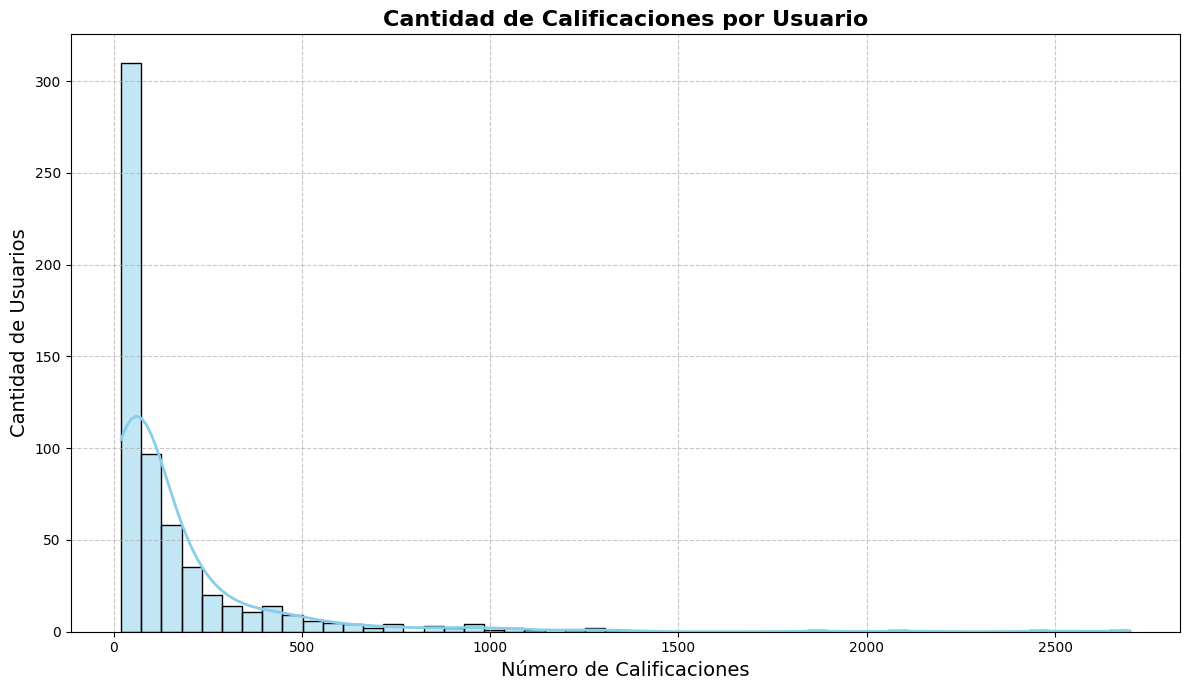

In [139]:
# Contar el número de calificaciones por usuario
ratings_per_user = df_ratings.groupby('userId')['rating'].count()

# Crear el histograma de la cantidad de calificaciones por usuario
plt.figure(figsize=(12, 7))

# Crear el histograma con KDE
ax = sns.histplot(ratings_per_user, bins=50, kde=True, color='skyblue', line_kws={'color': 'red', 'linewidth': 2})

# Añadir título y etiquetas
plt.title('Cantidad de Calificaciones por Usuario', fontsize=16, fontweight='bold')
plt.xlabel('Número de Calificaciones', fontsize=14)
plt.ylabel('Cantidad de Usuarios', fontsize=14)

# Mejorar el diseño
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


In [140]:
# Explodir los géneros para contar las películas por género
genres_exploded = df_movies['genres'].str.split('|', expand=True).stack().reset_index(level=1, drop=True)

# Contar la cantidad de películas por género
genre_counts = genres_exploded.value_counts().reset_index()
genre_counts.columns = ['Género', 'Cantidad de Películas']

# Crear el histograma interactivo
fig = px.bar(
    genre_counts,
    y='Género',
    x='Cantidad de Películas',
    title='Distribución de Películas por Género',
    labels={'Género': 'Género', 'Cantidad de Películas': 'Cantidad de Películas'},
    color='Cantidad de Películas',
    color_continuous_scale='viridis',  # Paleta de colores atractiva
    orientation='h'  # Orientar el gráfico horizontalmente
)

# Personalizar el diseño
fig.update_layout(
    title_font_size=16,
    xaxis_title='Cantidad de Películas',
    yaxis_title='Género',
    yaxis=dict(categoryorder='total ascending'),  # Ordenar por cantidad de películas
    xaxis=dict(showgrid=True, zeroline=True),  # Añadir cuadrícula en el eje X
    coloraxis_colorbar=dict(title='Cantidad de Películas')  # Barra de color para la escala
)

# Mostrar el gráfico
fig.show()


In [141]:
# Contar la cantidad de calificaciones por película
ratings_per_movie = df_ratings.groupby('movieId')['rating'].count().reset_index()
ratings_per_movie.columns = ['movieId', 'Number of Ratings']

# Crear el histograma
fig = go.Figure()

# Añadir el histograma
fig.add_trace(go.Histogram(
    x=ratings_per_movie['Number of Ratings'],
    nbinsx=50,
    marker=dict(color='skyblue'),
    name='Número de Calificaciones'
))

# Añadir la línea de densidad KDE
fig.add_trace(go.Histogram(
    x=ratings_per_movie['Number of Ratings'],
    histnorm='probability density',
    name='KDE',
    marker=dict(color='red', opacity=0.5),
    yaxis='y2'
))

# Actualizar el diseño
fig.update_layout(
    title='Cantidad de Calificaciones por Película',
    xaxis_title='Número de Calificaciones',
    yaxis_title='Cantidad de Películas',
    yaxis2=dict(
        title='Densidad',
        overlaying='y',
        side='right'
    ),
    title_font_size=16,
    xaxis=dict(showgrid=True, zeroline=True),
    yaxis=dict(showgrid=True, zeroline=True)
)

# Mostrar el gráfico
fig.show()


In [142]:
# Total calificaciones por cada puntuación
df_ratings['rating'].value_counts()

,count
rating,
4.00,26818
3.00,20047
5.00,13211
3.50,13136
4.50,8551
2.00,7551
2.50,5550
1.00,2811
1.50,1791


In [143]:
# Calcular el total de observaciones
total = len(df_ratings['rating'])

# Contar las frecuencias de cada calificación
hist_data = df_ratings['rating'].value_counts().sort_index()
x = hist_data.index
y = hist_data.values
percentages = [f'{value / total * 100:.1f}%' for value in y]

# Crear la figura
fig = go.Figure()

# Añadir la barra del histograma
fig.add_trace(go.Bar(
    x=x,
    y=y,
    text=percentages,
    textposition='outside',
    marker_color='skyblue',
    marker_line_color='black',
    marker_line_width=1.5
))

# Actualizar el diseño
fig.update_layout(
    title='Distribución de las Calificaciones',
    xaxis_title='Calificación',
    yaxis_title='Frecuencia',
    xaxis=dict(
        tickmode='linear',
        tickvals=list(range(int(min(x)), int(max(x)) + 1)),  # Asegúrate de usar enteros
        ticktext=[f'{i}' for i in range(int(min(x)), int(max(x)) + 1)],
        showgrid=True,
        zeroline=True,
        showline=True,
        linecolor='black'
    ),
    yaxis=dict(
        showgrid=True,
        zeroline=True,
        showline=True,
        linecolor='black'
    ),
    margin=dict(l=50, r=50, t=50, b=50)  # Ajustar márgenes para una mejor visualización
)

# Mostrar el gráfico
fig.show()


In [144]:
# Crear el boxplot
fig = px.box(df_ratings, x='rating',
             title='Distribución de las Calificaciones',
             labels={'rating': 'Calificación'},
             template='plotly_white')

# Personalizar el diseño
fig.update_layout(
    xaxis_title='Calificación',
    yaxis_title='',  # No es necesario un ylabel en un boxplot horizontal
    title_font_size=16,
    xaxis_title_font_size=14,
    yaxis_title_font_size=14,
    margin=dict(l=50, r=50, t=50, b=50)  # Ajustar márgenes para una mejor visualización
)

# Mostrar el gráfico
fig.show()


In [145]:
df_final = pd.merge(df_ratings, df_movies, on='movieId')
df_final.head()

,userId,movieId,rating,timestamp,title,genres,content,genre_set
0,1,1,4.00,2000-07-30 18:45:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Comedy, Animation, Adventure, Fantasy, Children}"
1,5,1,4.00,1996-11-08 06:36:02,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Comedy, Animation, Adventure, Fantasy, Children}"
2,7,1,4.50,2005-01-25 06:52:26,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Comedy, Animation, Adventure, Fantasy, Children}"
3,15,1,2.50,2017-11-13 12:59:30,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Comedy, Animation, Adventure, Fantasy, Children}"
4,17,1,4.50,2011-05-18 05:28:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Comedy, Animation, Adventure, Fantasy, Children}"


#**3. Estrategias de Recomendación**


---

In [146]:
df_final.head()

,userId,movieId,rating,timestamp,title,genres,content,genre_set
0,1,1,4.00,2000-07-30 18:45:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Comedy, Animation, Adventure, Fantasy, Children}"
1,5,1,4.00,1996-11-08 06:36:02,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Comedy, Animation, Adventure, Fantasy, Children}"
2,7,1,4.50,2005-01-25 06:52:26,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Comedy, Animation, Adventure, Fantasy, Children}"
3,15,1,2.50,2017-11-13 12:59:30,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Comedy, Animation, Adventure, Fantasy, Children}"
4,17,1,4.50,2011-05-18 05:28:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Comedy, Animation, Adventure, Fantasy, Children}"


##**3.1 Recomendación no personalizada**

**Top 10 Peliculas mas votadas**

In [149]:
def recomendacion_populares():
    global df_final  # Definir la variable global

    # Paso 1: Contar cuántas veces cada película ha sido votada
    vote_counts = df_final['title'].value_counts()

    # Paso 2: Filtrar las películas que tienen más de 210 votos
    filtered_vote_counts = vote_counts[vote_counts > 210]
    df_popular_movies = df_final[df_final['title'].isin(filtered_vote_counts.index)]

    # Paso 3: Calcular el rating promedio de cada película en df_popular_movies
    mean_ratings = df_popular_movies.groupby('title')['rating'].mean()
    vote_counts = df_popular_movies.groupby('title')['rating'].count()

    # Paso 4: Crear un nuevo DataFrame df_movie_stats con mean_rating y vote_count
    df_movie_stats = pd.DataFrame({
        'mean_rating': mean_ratings,
        'vote_count': vote_counts
    }).reset_index()

    # Paso 5: Filtrar df_movie_stats para obtener las 10 películas más votadas
    top_movies = df_movie_stats.sort_values(by='vote_count', ascending=False).head(10)

    # Paso 6: Ordenar las 10 películas más populares por rating promedio
    top_movies_sorted = top_movies.sort_values(by='mean_rating', ascending=False)

    # Imprimir las 10 películas más populares ordenadas por el rating promedio
    print(top_movies_sorted)

    # Retornar el DataFrame con los resultados
    return top_movies_sorted


# Llamar a la función para obtener las recomendaciones
recomendacion_populares()


                                        title  mean_rating  vote_count
7            Shawshank Redemption, The (1994)         4.43         317
9   Star Wars: Episode IV - A New Hope (1977)         4.23         251
6                     Schindler's List (1993)         4.22         220
5                         Pulp Fiction (1994)         4.20         307
4                          Matrix, The (1999)         4.19         278
2                         Forrest Gump (1994)         4.16         329
8            Silence of the Lambs, The (1991)         4.16         279
0                           Braveheart (1995)         4.03         237
11          Terminator 2: Judgment Day (1991)         3.97         224
3                        Jurassic Park (1993)         3.75         238


,title,mean_rating,vote_count
7,"Shawshank Redemption, The (1994)",4.43,317
9,Star Wars: Episode IV - A New Hope (1977),4.23,251
6,Schindler's List (1993),4.22,220
5,Pulp Fiction (1994),4.20,307
4,"Matrix, The (1999)",4.19,278
2,Forrest Gump (1994),4.16,329
8,"Silence of the Lambs, The (1991)",4.16,279
0,Braveheart (1995),4.03,237
11,Terminator 2: Judgment Day (1991),3.97,224
3,Jurassic Park (1993),3.75,238


**Promedio Bayesiano**

-----
El promedio bayesiano es una técnica útil para ajustar las calificaciones de las películas teniendo en cuenta la cantidad de votos y el rating promedio global. La idea es que las películas con menos votos tendrán un rating ajustado que se aproxima más al rating promedio global, mientras que las películas con más votos tendrán su rating ajustado más cerca de su rating real.

-----

Cálculo del Promedio Bayesiano

La fórmula general para calcular el rating bayesiano ajustado es:

Rating Bayesiano=(C⋅m)+(R⋅v)C+vRating Bayesiano=C+v(C⋅m)+(R⋅v)​

donde:
1.  CC es el rating promedio global.
2.    mm es el número mínimo de votos considerado como el umbral de referencia.
3.    RR es el rating promedio de la película.
4.   vv es el número de votos de la película.

Sin embargo, en lugar de fijar un umbral mm de forma arbitraria, ajustaremos las calificaciones según la distribución de votos en el dataset.
Pasos para la Función

1.    Calcular el Rating Promedio Global.
2.    Calcular el Rating Promedio y el Número de Votos por Película.
3.    Calcular el Promedio Bayesiano para Cada Película.
4.    Ordenar y Mostrar las Películas Basadas en el Rating Bayesiano Ajustado.

In [150]:
def recomendacion_populares1():
    global df_final  # Definir la variable global

    # Paso 1: Calcular el rating promedio global
    global_mean_rating = df_final['rating'].mean()

    # Paso 2: Contar cuántas veces cada película ha sido votada
    vote_counts = df_final['title'].value_counts()

    # Establecer el umbral mínimo de votos para la filtración
    min_votes_threshold = 50  # Ajusta este valor según sea necesario

    # Filtrar las películas que tienen al menos min_votes_threshold votos
    filtered_vote_counts = vote_counts[vote_counts >= min_votes_threshold]
    df_popular_movies = df_final[df_final['title'].isin(filtered_vote_counts.index)]

    # Paso 3: Calcular el rating promedio y el número de votos por película en df_popular_movies
    mean_ratings = df_popular_movies.groupby('title')['rating'].mean()
    vote_counts = df_popular_movies.groupby('title')['rating'].count()

    # Paso 4: Calcular el promedio bayesiano
    # Definir el peso basado en la cantidad de votos
    m = min_votes_threshold
    df_movie_stats = pd.DataFrame({
        'mean_rating': mean_ratings,
        'vote_count': vote_counts
    }).reset_index()

    df_movie_stats['bayesian_rating'] = (
        (global_mean_rating * m + df_movie_stats['mean_rating'] * df_movie_stats['vote_count'])
        / (m + df_movie_stats['vote_count'])
    )

    # Paso 5: Filtrar y ordenar las películas por rating bayesiano
    top_movies = df_movie_stats.sort_values(by='bayesian_rating', ascending=False).head(10)

    # Imprimir las 10 películas más populares ordenadas por el rating bayesiano
    print(top_movies[['title', 'bayesian_rating', 'vote_count']])

    # Retornar el DataFrame con los resultados
    return top_movies[['title', 'bayesian_rating', 'vote_count']]


# Llamar a la función para obtener las recomendaciones
recomendacion_populares1()


                                                 title  bayesian_rating  \
349                   Shawshank Redemption, The (1994)             4.30   
154                                  Fight Club (1999)             4.13   
173                              Godfather, The (1972)             4.13   
384          Star Wars: Episode IV - A New Hope (1977)             4.11   
318                                Pulp Fiction (1994)             4.10   
424                         Usual Suspects, The (1995)             4.09   
341                            Schindler's List (1993)             4.09   
264                                 Matrix, The (1999)             4.09   
385  Star Wars: Episode V - The Empire Strikes Back...             4.08   
159                                Forrest Gump (1994)             4.08   

     vote_count  
349         317  
154         218  
173         192  
384         251  
318         307  
424         204  
341         220  
264         278  
385         

,title,bayesian_rating,vote_count
349,"Shawshank Redemption, The (1994)",4.30,317
154,Fight Club (1999),4.13,218
173,"Godfather, The (1972)",4.13,192
384,Star Wars: Episode IV - A New Hope (1977),4.11,251
318,Pulp Fiction (1994),4.10,307
424,"Usual Suspects, The (1995)",4.09,204
341,Schindler's List (1993),4.09,220
264,"Matrix, The (1999)",4.09,278
385,Star Wars: Episode V - The Empire Strikes Back...,4.08,211
159,Forrest Gump (1994),4.08,329


In [152]:
def recomendacion_populares2():
    global df_final  # Definir la variable global

    # Paso 1: Calcular el rating promedio global
    global_mean_rating = df_final['rating'].mean()

    # Paso 2: Contar cuántas veces cada película ha sido votada
    vote_counts = df_final['movieId'].value_counts()

    # Establecer el umbral mínimo de votos para la filtración
    min_votes_threshold = 50  # Ajusta este valor según sea necesario

    # Filtrar las películas que tienen al menos min_votes_threshold votos
    filtered_vote_counts = vote_counts[vote_counts >= min_votes_threshold]
    df_popular_movies = df_final[df_final['movieId'].isin(filtered_vote_counts.index)]

    # Paso 3: Calcular el rating promedio y el número de votos por película en df_popular_movies
    mean_ratings = df_popular_movies.groupby('movieId')['rating'].mean()
    vote_counts = df_popular_movies.groupby('movieId')['rating'].count()

    # Crear un DataFrame para estadísticas de películas
    df_movie_stats = pd.DataFrame({
        'mean_rating': mean_ratings,
        'vote_count': vote_counts
    }).reset_index()

    # Añadir la columna de título al DataFrame de estadísticas de películas
    df_movie_stats = df_movie_stats.merge(df_popular_movies[['movieId', 'title']].drop_duplicates(), on='movieId', how='left')

    # Paso 4: Calcular el promedio bayesiano
    # Definir el peso basado en la cantidad de votos
    m = min_votes_threshold
    df_movie_stats['bayesian_rating'] = (
        (global_mean_rating * m + df_movie_stats['mean_rating'] * df_movie_stats['vote_count'])
        / (m + df_movie_stats['vote_count'])
    )

    # Paso 5: Filtrar y ordenar las películas por rating bayesiano
    top_movies = df_movie_stats.sort_values(by='bayesian_rating', ascending=False).head(10)

    # Imprimir las 10 películas más populares ordenadas por el rating bayesiano
    print(top_movies[['movieId', 'title', 'bayesian_rating', 'vote_count']])

    # Retornar el DataFrame con los resultados
    return top_movies[['movieId', 'title', 'bayesian_rating', 'vote_count']]



# Llamar a la función para obtener las recomendaciones
recomendacion_populares2()


     movieId                                              title  \
53       318                   Shawshank Redemption, The (1994)   
277     2959                                  Fight Club (1999)   
118      858                              Godfather, The (1972)   
44       260          Star Wars: Episode IV - A New Hope (1977)   
49       296                                Pulp Fiction (1994)   
18        50                         Usual Suspects, The (1995)   
87       527                            Schindler's List (1993)   
252     2571                                 Matrix, The (1999)   
142     1196  Star Wars: Episode V - The Empire Strikes Back...   
62       356                                Forrest Gump (1994)   

     bayesian_rating  vote_count  
53              4.30         317  
277             4.13         218  
118             4.13         192  
44              4.11         251  
49              4.10         307  
18              4.09         204  
87              4

,movieId,title,bayesian_rating,vote_count
53,318,"Shawshank Redemption, The (1994)",4.30,317
277,2959,Fight Club (1999),4.13,218
118,858,"Godfather, The (1972)",4.13,192
44,260,Star Wars: Episode IV - A New Hope (1977),4.11,251
49,296,Pulp Fiction (1994),4.10,307
18,50,"Usual Suspects, The (1995)",4.09,204
87,527,Schindler's List (1993),4.09,220
252,2571,"Matrix, The (1999)",4.09,278
142,1196,Star Wars: Episode V - The Empire Strikes Back...,4.08,211
62,356,Forrest Gump (1994),4.08,329


In [153]:
def recomendacion_populares3():
    global df_final  # Definir la variable global

    # Paso 1: Calcular el rating promedio global
    global_mean_rating = df_final['rating'].mean()

    # Paso 2: Calcular el rating promedio y el número de votos por película
    vote_counts = df_final['movieId'].value_counts()
    mean_ratings = df_final.groupby('movieId')['rating'].mean()
    vote_counts = df_final.groupby('movieId')['rating'].count()

    # Crear un DataFrame para las estadísticas de películas
    df_movie_stats = pd.DataFrame({
        'mean_rating': mean_ratings,
        'vote_count': vote_counts
    }).reset_index()

    # Paso 3: Calcular el promedio bayesiano
    # Calcular el número de votos mínimo como el 5% de la cantidad máxima de votos
    m = vote_counts.quantile(0.05)  # Usamos el percentil 5 como umbral dinámico
    df_movie_stats['bayesian_rating'] = (
        (global_mean_rating * m + df_movie_stats['mean_rating'] * df_movie_stats['vote_count'])
        / (m + df_movie_stats['vote_count'])
    )

    # Paso 4: Filtrar y ordenar las películas por rating bayesiano
    top_movies = df_movie_stats.sort_values(by='bayesian_rating', ascending=False).head(10)

    # Imprimir las 10 películas más populares ordenadas por el rating bayesiano
    print(top_movies[['movieId', 'mean_rating', 'bayesian_rating', 'vote_count']])

    # Retornar el DataFrame con los resultados
    return top_movies[['movieId', 'mean_rating', 'bayesian_rating', 'vote_count']]


# Llamar a la función para obtener las recomendaciones
recomendacion_populares3()


      movieId  mean_rating  bayesian_rating  vote_count
4390     6460         4.90             4.67           5
9600   177593         4.75             4.61           8
87         99         5.00             4.50           2
7347    78836         5.00             4.50           2
2593     3473         5.00             4.50           2
48         53         5.00             4.50           2
4583     6818         5.00             4.50           2
869      1151         5.00             4.50           2
4384     6442         5.00             4.50           2
8518   115122         4.83             4.50           3


,movieId,mean_rating,bayesian_rating,vote_count
4390,6460,4.90,4.67,5
9600,177593,4.75,4.61,8
87,99,5.00,4.50,2
7347,78836,5.00,4.50,2
2593,3473,5.00,4.50,2
48,53,5.00,4.50,2
4583,6818,5.00,4.50,2
869,1151,5.00,4.50,2
4384,6442,5.00,4.50,2
8518,115122,4.83,4.50,3


In [154]:
def recomendacion_populares4():
    global df_final  # Definir la variable global

    # Paso 1: Calcular el rating promedio global
    global_mean_rating = df_final['rating'].mean()

    # Paso 2: Calcular el rating promedio y el número de votos por película
    vote_counts = df_final['movieId'].value_counts()
    mean_ratings = df_final.groupby('movieId')['rating'].mean()
    vote_counts = df_final.groupby('movieId')['rating'].count()

    # Crear un DataFrame para las estadísticas de películas
    df_movie_stats = pd.DataFrame({
        'mean_rating': mean_ratings,
        'vote_count': vote_counts
    }).reset_index()

    # Paso 3: Calcular el promedio bayesiano
    # Calcular el número de votos mínimo como el 5% de la cantidad máxima de votos
    m = vote_counts.quantile(0.05)  # Usamos el percentil 5 como umbral dinámico
    df_movie_stats['weighted_score'] = (
        (global_mean_rating * m + df_movie_stats['mean_rating'] * df_movie_stats['vote_count'])
        / (m + df_movie_stats['vote_count'])
    )

    # Paso 4: Filtrar y ordenar las películas por weighted_score
    top_movies = df_movie_stats.sort_values(by='weighted_score', ascending=False).head(10)

    # Imprimir las 10 películas más populares ordenadas por el weighted_score
    print(top_movies[['movieId', 'mean_rating', 'weighted_score', 'vote_count']])

    # Retornar el DataFrame con los resultados
    return top_movies[['movieId', 'mean_rating', 'weighted_score', 'vote_count']]

# Llamar a la función para obtener las recomendaciones
recomendacion_populares4()


      movieId  mean_rating  weighted_score  vote_count
4390     6460         4.90            4.67           5
9600   177593         4.75            4.61           8
87         99         5.00            4.50           2
7347    78836         5.00            4.50           2
2593     3473         5.00            4.50           2
48         53         5.00            4.50           2
4583     6818         5.00            4.50           2
869      1151         5.00            4.50           2
4384     6442         5.00            4.50           2
8518   115122         4.83            4.50           3


,movieId,mean_rating,weighted_score,vote_count
4390,6460,4.90,4.67,5
9600,177593,4.75,4.61,8
87,99,5.00,4.50,2
7347,78836,5.00,4.50,2
2593,3473,5.00,4.50,2
48,53,5.00,4.50,2
4583,6818,5.00,4.50,2
869,1151,5.00,4.50,2
4384,6442,5.00,4.50,2
8518,115122,4.83,4.50,3


##**3.2 Recomendación Content-Based**

----


1. Definición de la Similitud de Jaccard

La similitud de Jaccard mide la similitud entre dos conjuntos como la razón entre la intersección y la unión de los conjuntos. La fórmula es:

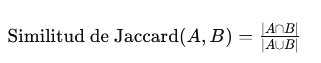

donde AA y BB son los conjuntos de características de los ítems.


**Recomendación Personalizada**

In [167]:
# Función para calcular la Similitud de Jaccard
def jaccard_similarity(set1, set2):
    """
    Calcula la similitud de Jaccard entre dos conjuntos.

    :param set1: Primer conjunto
    :param set2: Segundo conjunto
    :return: Similitud de Jaccard entre set1 y set2
    """
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

# Función de Recomendación basada en Similitud de Jaccard
def recomendacion_jaccard(movie_title):
    """
    Recomienda películas similares a la película especificada utilizando similitud de Jaccard.

    :param movie_title: Título de la película para la cual encontrar recomendaciones
    :return: DataFrame con las películas más similares ordenadas por similitud de Jaccard
    """
    # debemos df_movies disponible en el entorno global
    global df_movies

    # Paso 1: Crear un diccionario que asocia cada película con su conjunto de géneros
    movie_genres = df_movies.set_index('title')['genres'].apply(lambda x: set(x.split('|'))).to_dict()

    # Paso 2: Obtener el conjunto de géneros de la película de entrada
    input_movie_genres = movie_genres.get(movie_title)

    if input_movie_genres is None:
        print(f"La película '{movie_title}' no se encuentra en el dataset.")
        return None

    # Paso 3: Calcular la similitud de Jaccard entre la película de entrada y todas las demás
    similarities = {}
    for title, genres in movie_genres.items():
        if title != movie_title:
            similarity = jaccard_similarity(input_movie_genres, genres)
            similarities[title] = similarity

    # Paso 4: Crear un DataFrame con las películas más similares según la similitud de Jaccard
    df_similar_movies = pd.DataFrame(list(similarities.items()), columns=['title', 'jaccard_similarity'])

    # Ordenar el DataFrame por la similitud de Jaccard en orden descendente
    df_similar_movies = df_similar_movies.sort_values(by='jaccard_similarity', ascending=False).head(10)

    return df_similar_movies


# Llamar a la función para ver el resultado en un DataFrame
df_recomendaciones_jaccard = recomendacion_jaccard("Toy Story (1995)")

# Mostrar los resultados
df_recomendaciones_jaccard


,title,jaccard_similarity
2354,Toy Story 2 (1999),1.00
6192,"Wild, The (2006)",1.00
6945,"Tale of Despereaux, The (2008)",1.00
2808,"Adventures of Rocky and Bullwinkle, The (2000)",1.00
3567,"Monsters, Inc. (2001)",1.00
8216,Turbo (2013),1.00
9425,Moana (2016),1.00
1705,Antz (1998),1.00
2999,"Emperor's New Groove, The (2000)",1.00
7757,Asterix and the Vikings (Astérix et les Viking...,1.00


**Recomendaciones Jaccard con df_final**

In [168]:
import pandas as pd

# Función para calcular la Similitud de Jaccard
def jaccard_similarity(set1, set2):
    """
    Calcula la similitud de Jaccard entre dos conjuntos.

    :param set1: Primer conjunto de géneros
    :param set2: Segundo conjunto de géneros
    :return: Similitud de Jaccard entre set1 y set2
    """
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

# Función de Recomendación basada en Similitud de Jaccard utilizando df_final
def recomendacion_jaccard(df_final, movie_title):
    """
    Recomienda películas similares a la película especificada utilizando similitud de Jaccard.

    :param df_final: DataFrame que contiene películas y géneros
    :param movie_title: Título de la película para la cual encontrar recomendaciones
    :return: DataFrame con las películas más similares ordenadas por similitud de Jaccard
    """
    # Paso 1: Crear una columna con conjuntos de géneros
    if 'genres_set' not in df_final.columns:
        df_final['genres_set'] = df_final['genres'].apply(lambda x: set(x.split('|')))

    # Paso 2: Filtrar el DataFrame para eliminar duplicados y trabajar solo con un título de película
    df_unique_movies = df_final.drop_duplicates(subset=['title'])

    # Paso 3: Obtener el conjunto de géneros de la película de entrada
    input_movie_genres = df_unique_movies[df_unique_movies['title'] == movie_title]['genres_set']
    if input_movie_genres.empty:
        print(f"La película '{movie_title}' no se encuentra en el dataset.")
        return None
    input_movie_genres = input_movie_genres.values[0]

    # Paso 4: Calcular la similitud de Jaccard entre la película de entrada y todas las demás
    similarities = {}
    for index, row in df_unique_movies.iterrows():
        title = row['title']
        genres = row['genres_set']
        if title != movie_title:
            similarity = jaccard_similarity(input_movie_genres, genres)
            similarities[title] = similarity

    # Paso 5: Crear un DataFrame con las películas más similares según la similitud de Jaccard
    df_similar_movies = pd.DataFrame(list(similarities.items()), columns=['title', 'jaccard_similarity'])

    # Ordenar el DataFrame por la similitud de Jaccard en orden descendente
    df_similar_movies = df_similar_movies.sort_values(by='jaccard_similarity', ascending=False).head(10)

    return df_similar_movies


# Llamar a la función para ver el resultado en un DataFrame
df_recomendaciones_jaccard = recomendacion_jaccard(df_final, "Toy Story (1995)")

# Mostrar los resultados
df_recomendaciones_jaccard

,title,jaccard_similarity
3856,Asterix and the Vikings (Astérix et les Viking...,1.00
7202,"Wild, The (2006)",1.00
7891,Turbo (2013),1.00
734,Toy Story 2 (1999),1.00
4621,Moana (2016),1.00
4190,"Tale of Despereaux, The (2008)",1.00
1801,"Emperor's New Groove, The (2000)",1.00
1591,Antz (1998),1.00
1904,Shrek the Third (2007),1.00
1756,"Adventures of Rocky and Bullwinkle, The (2000)",1.00


Para comparar los dos DataFrames generados por las funciones de recomendación basadas en similitud de Jaccard, primero necesitamos definir dos aspectos importantes:

**1.   Similitud de Jaccard:** La similitud de Jaccard mide qué tan similares son dos conjuntos en términos de la proporción de elementos comunes sobre el total de elementos únicos en ambos conjuntos.

**2.    Recomendaciones:** Comparar las recomendaciones proporcionadas por el enfoque basado en similitud de Jaccard para cada uno de los DataFrames puede ayudar a identificar cuáles películas son similares según este método.


In [170]:
# DataFrame de recomendaciones para "Toy Story (1995)"
df_recomendaciones_jaccard_toy_story = recomendacion_jaccard(df_final, "Toy Story (1995)")

# DataFrame de recomendaciones para "Jumanji (1995)"
df_recomendaciones_jaccard_jumanji = recomendacion_jaccard(df_final, "Jumanji (1995)")

print("Recomendaciones basadas en 'Toy Story (1995)':")
print(df_recomendaciones_jaccard_toy_story)

print("\nRecomendaciones basadas en 'Jumanji (1995)':")
print(df_recomendaciones_jaccard_jumanji)



Recomendaciones basadas en 'Toy Story (1995)':
                                                  title  jaccard_similarity
3856  Asterix and the Vikings (Astérix et les Viking...                1.00
7202                                   Wild, The (2006)                1.00
7891                                       Turbo (2013)                1.00
734                                  Toy Story 2 (1999)                1.00
4621                                       Moana (2016)                1.00
4190                     Tale of Despereaux, The (2008)                1.00
1801                   Emperor's New Groove, The (2000)                1.00
1591                                        Antz (1998)                1.00
1904                             Shrek the Third (2007)                1.00
1756     Adventures of Rocky and Bullwinkle, The (2000)                1.00

Recomendaciones basadas en 'Jumanji (1995)':
                                                  title  jaccard_simila

las diferencias en las películas recomendadas y en las similitudes de Jaccard. Podemos comparar los títulos y la similitud para ver cuáles películas se recomiendan para cada entrada.

Differences in Similarity Scores:

1.  **Similitudes:** Las similitudes pueden variar dependiendo de los géneros de las películas. Por ejemplo, "Toy Story (1995)" y "Jumanji (1995)" tienen géneros diferentes, por lo que las recomendaciones basadas en estas películas también serán diferentes.

Recomendaciones y Decisiones

1.    **Recomendaciones Basadas en la Película de Entrada:**
        Las recomendaciones para "Toy Story (1995)" estarán influenciadas por sus géneros específicos (Animation, Adventure, Comedy).
        Las recomendaciones para "Jumanji (1995)" se basarán en su propio conjunto de géneros (Adventure, Children, Fantasy).

2.    **Elección de la Mejor Recomendación:**
        Diversidad de Géneros: Si estás buscando diversidad en tus recomendaciones, puedes comparar cómo se diversifican las recomendaciones para diferentes títulos.
        Exactitud de las Recomendaciones: Asegúrate de que las recomendaciones sean coherentes con los géneros y temas de la película de entrada.

3.    **Toma de Decisiones:**
        Utiliza Recomendaciones con Alta Similitud: Para una recomendación más precisa, considera las películas con alta similitud de Jaccard.
        Diversifica el Enfoque: Si deseas obtener una variedad más amplia, considera recomendaciones de diferentes títulos o ajusta el umbral de similitud.

In [178]:
# Función para calcular la Similitud de Jaccard
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

# Función de Recomendación basada en Similitud de Jaccard utilizando df_final
def recomendacion_jaccard(df_final, movie_title):
    # Paso 1: Filtrar el DataFrame para eliminar duplicados y trabajar solo con un título de película
    df_unique_movies = df_final.drop_duplicates(subset=['title'])

    # Paso 2: Obtener el conjunto de géneros de la película de entrada
    df_unique_movies['genres_set'] = df_unique_movies['genres'].apply(lambda x: set(x.split('|')))
    input_movie_genres = df_unique_movies[df_unique_movies['title'] == movie_title]['genres_set'].values
    if len(input_movie_genres) == 0:
        print(f"La película '{movie_title}' no se encuentra en el dataset.")
        return None
    input_movie_genres = input_movie_genres[0]

    # Paso 3: Calcular la similitud de Jaccard entre la película de entrada y todas las demás
    similarities = {}
    for index, row in df_unique_movies.iterrows():
        title = row['title']
        genres = row['genres_set']
        if title != movie_title:
            similarity = jaccard_similarity(input_movie_genres, genres)
            similarities[title] = similarity

    # Paso 4: Crear un DataFrame con las películas más similares según la similitud de Jaccard
    df_similar_movies = pd.DataFrame(list(similarities.items()), columns=['title', 'jaccard_similarity'])

    # Ordenar el DataFrame por la similitud de Jaccard en orden descendente
    df_similar_movies = df_similar_movies.sort_values(by='jaccard_similarity', ascending=False).head(10)

    return df_similar_movies

# Llamar a la función para ver el resultado en un DataFrame
df_recomendaciones_jaccard_toy_story = recomendacion_jaccard(df_final, "Toy Story (1995)")
df_recomendaciones_jaccard_jumanji = recomendacion_jaccard(df_final, "Jumanji (1995)")

# Verifica el contenido de los DataFrames
print("Recomendaciones basadas en 'Toy Story (1995)':")
print(df_recomendaciones_jaccard_toy_story)

print("\nRecomendaciones basadas en 'Jumanji (1995)':")
print(df_recomendaciones_jaccard_jumanji)

# Verifica las diferencias en las similitudes
common_titles = set(df_recomendaciones_jaccard_toy_story['title']) & set(df_recomendaciones_jaccard_jumanji['title'])

if not common_titles:
    print("No hay títulos comunes en ambas recomendaciones.")
else:
    print("Películas comunes en ambas recomendaciones:")
    for title in common_titles:
        similarity_toy_story = df_recomendaciones_jaccard_toy_story[df_recomendaciones_jaccard_toy_story['title'] == title]['jaccard_similarity'].values[0]
        similarity_jumanji = df_recomendaciones_jaccard_jumanji[df_recomendaciones_jaccard_jumanji['title'] == title]['jaccard_similarity'].values[0]
        print(f"{title}: Similitud en 'Toy Story (1995)' = {similarity_toy_story:.2f}, Similitud en 'Jumanji (1995)' = {similarity_jumanji:.2f}")


Recomendaciones basadas en 'Toy Story (1995)':
                                                  title  jaccard_similarity
3856  Asterix and the Vikings (Astérix et les Viking...                1.00
7202                                   Wild, The (2006)                1.00
7891                                       Turbo (2013)                1.00
734                                  Toy Story 2 (1999)                1.00
4621                                       Moana (2016)                1.00
4190                     Tale of Despereaux, The (2008)                1.00
1801                   Emperor's New Groove, The (2000)                1.00
1591                                        Antz (1998)                1.00
1904                             Shrek the Third (2007)                1.00
1756     Adventures of Rocky and Bullwinkle, The (2000)                1.00

Recomendaciones basadas en 'Jumanji (1995)':
                                                  title  jaccard_simila

Conclusión

Las recomendaciones basadas en similitud de Jaccard pueden variar dependiendo de los géneros de las películas de entrada. Comparar estos resultados te ayudará a entender cómo los géneros afectan las recomendaciones y te permitirá elegir la mejor estrategia para personalizar recomendaciones en función de los intereses específicos del usuario.

###**3.2.2 Similitud de Coseno con TF-IDF**
---


La similitud de coseno mide la similitud entre dos vectores en un espacio vectorial. En el contexto de procesamiento de texto:


1. Representación de Documentos: Primero, cada documento (en este caso, cada película) se representa como un vector en un espacio de características basado en las palabras del documento. Para esto, se usa el TF-IDF (Term Frequency-Inverse Document Frequency).

2. Cálculo de Similitud: La similitud de coseno entre dos vectores se calcula utilizando el producto escalar de los vectores dividido por el producto de sus normas (longitudes). Esta métrica resulta en un valor entre -1 y 1, donde 1 indica que los vectores son idénticos (y por tanto los documentos son muy similares), y 0 indica que no tienen ninguna similitud.

In [190]:
#Calcular la Matriz TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Calculamos la matriz TF-IDF para df_movies['content']
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df_movies['content'])

# Calculamos la matriz de similitud de coseno
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

TF-IDF: Calcula el peso de cada palabra en un documento en relación con todos los documentos. La frecuencia de término (TF) mide cuántas veces aparece una palabra en un documento, mientras que el inverso de la frecuencia de documento (IDF) mide cuántos documentos contienen esa palabra. La combinación de TF e IDF da el TF-IDF, que pondera la importancia de cada palabra.

In [189]:
def recomendacion_tf_idf(movie_id, n_recomendations=100):
    # Obtenemos el índice de la película en df_movies usando el movie_id
    idx = df_movies[df_movies['movieId'] == movie_id].index[0]

    # Obtenemos las puntuaciones de similitud de coseno para todas las películas
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Ordenamos las películas por las puntuaciones de similitud en orden descendente
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Filtramos la película de entrada (la primera en la lista después de ordenar)
    sim_scores = sim_scores[1:]

    # Obtenemos los índices de las n_recommendations películas más similares
    sim_scores = sim_scores[:n_recomendations]

    # Obtenemos los índices y las puntuaciones de las películas recomendadas
    movie_indices = [i[0] for i in sim_scores]
    movie_scores = [i[1] for i in sim_scores]

    # Creamos un DataFrame con las películas recomendadas
    recomended_movies = df_movies.iloc[movie_indices].copy()
    recomended_movies['similarity_score'] = movie_scores

    return recomended_movies[['movieId', 'title', 'genres', 'similarity_score']]


recommended_movies_df


,movieId,title,genres,similarity_score
1706,2294,Antz (1998),Adventure|Animation|Children|Comedy|Fantasy,1.00
2355,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,1.00
2809,3754,"Adventures of Rocky and Bullwinkle, The (2000)",Adventure|Animation|Children|Comedy|Fantasy,1.00
3000,4016,"Emperor's New Groove, The (2000)",Adventure|Animation|Children|Comedy|Fantasy,1.00
3568,4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy,1.00
6194,45074,"Wild, The (2006)",Adventure|Animation|Children|Comedy|Fantasy,1.00
6486,53121,Shrek the Third (2007),Adventure|Animation|Children|Comedy|Fantasy,1.00
6948,65577,"Tale of Despereaux, The (2008)",Adventure|Animation|Children|Comedy|Fantasy,1.00
7760,91355,Asterix and the Vikings (Astérix et les Viking...,Adventure|Animation|Children|Comedy|Fantasy,1.00
8219,103755,Turbo (2013),Adventure|Animation|Children|Comedy|Fantasy,1.00


Este enfoque de recomendación basada en contenido utiliza la similitud de coseno para encontrar películas similares en función del contenido textual, lo cual es útil cuando se busca una recomendación basada en descripciones u otros atributos textuales de las películas.

Similitud de Coseno: Calcula la similitud entre todos los pares de documentos en la matriz TF-IDF. Los valores resultantes son una matriz de similitud en la que cada entrada (i, j) representa la similitud entre el documento i y el documento j.

**Decidir Qué Similitud Usar**

1.    Tipo de Datos:
        Similitud de Coseno con TF-IDF es útil cuando trabajas con texto y quieres capturar la relevancia de las palabras en documentos.
        Similitud de Jaccard es útil para datos categóricos o binarios, como géneros de películas, para comparar conjuntos de características.

2.    Relevancia de Recomendaciones:
        Evalúa si las recomendaciones que obtienes son relevantes para el usuario. Puedes hacer esto manualmente o mediante métricas de evaluación, como la precisión, la cobertura o la tasa de clics.

3.    Diversidad de Resultados:
        Considera si la métrica proporciona una diversidad adecuada en las recomendaciones. Algunas métricas pueden llevar a recomendaciones más variadas que otras.

4.    Evaluación Empírica:
        Realiza pruebas con usuarios reales o con datos de prueba para ver cuál métrica ofrece mejores resultados en términos de satisfacción del usuario.



##**3.3 Recomendación Collaborative Filtering**
---